---
## 📦 Section 1 — Install & Import

In [5]:
!pip install Sastrawi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.1 MB/s eta 0:00:00


In [6]:
import os, re, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print('✅ Semua library berhasil diimport!')

✅ Semua library berhasil diimport!


---
## 📂 Section 2 — Upload & Load Dataset

In [7]:
from google.colab import files
print('📤 Upload DatasetGabungan.csv dan kamus_singkatan.csv')
uploaded = files.upload()

📤 Upload DatasetGabungan.csv dan kamus_singkatan.csv


Saving DatasetGabungan.csv to DatasetGabungan (1).csv
Saving kamus_singkatan.csv to kamus_singkatan (1).csv


In [10]:
def load_dataset(filepath, min_length=20):
    rows = []
    skipped = 0
    short = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i == 0: continue
            line = re.sub(r';+$', '', line.strip())
            if not line: continue

            match = re.match(
                r'^"?(happy|sadness|anger|fear|love|neutral),(.+)',
                line, re.IGNORECASE
            )
            if match:
                label = match.group(1).lower().strip()
                text = match.group(2).strip()
                text = re.sub(r'^"+ |"+ $', '', text)
                text = re.sub(r'""', '"', text)
                if len(text) >= min_length:
                    rows.append({'label': label, 'text': text})
                else:
                    short += 1
            else:
                skipped += 1

    df = pd.DataFrame(rows)
    print(f'✅ Dataset dimuat: {len(df)} baris')
    print(f'   Dilewati: {skipped} error, {short} teks terlalu pendek (<{min_length} char)')
    return df


df = load_dataset('DatasetGabungan.csv', min_length=20)
print(f'\n📊 Distribusi SEBELUM penggabungan:')
print(df['label'].value_counts().to_string())

✅ Dataset dimuat: 10821 baris
   Dilewati: 27 error, 660 teks terlalu pendek (<20 char)

📊 Distribusi SEBELUM penggabungan:
label
anger      2141
happy      2113
neutral    1878
sadness    1877
fear       1435
love       1377


---
## 🔀 Section 3 — Gabung Label + Eksplorasi Data

Menggabungkan label `love` ke `happy` → menjadi **5 kelas**.

In [11]:
# ========================================
# GABUNG: love → happy
# ========================================
love_count = (df['label'] == 'love').sum()
df['label'] = df['label'].replace('love', 'happy')

print(f'✅ {love_count} data "love" digabung ke "happy"')
print(f'   Total data: {len(df)}')
print()

# Mapping label
LABEL_MAP = {
    'happy': 'Senang',
    'sadness': 'Sedih',
    'anger': 'Marah',
    'fear': 'Takut',
    'neutral': 'Netral'
}
EMOJI_MAP = {
    'Senang': '😊', 'Sedih': '😢', 'Marah': '😡',
    'Takut': '😨', 'Netral': '😐'
}
COLOR_MAP = {
    'Senang': '#22C55E', 'Sedih': '#3B82F6', 'Marah': '#EF4444',
    'Takut': '#F59E0B', 'Netral': '#6B7280'
}

df['label_id'] = df['label'].map(LABEL_MAP)

print('📊 Distribusi SETELAH penggabungan (5 kelas):')
for label, count in df['label'].value_counts().items():
    pct = count / len(df) * 100
    emoji = EMOJI_MAP[LABEL_MAP[label]]
    print(f'   {emoji} {LABEL_MAP[label]:8s}: {count:5d} ({pct:.1f}%)')

✅ 1377 data "love" digabung ke "happy"
   Total data: 10821

📊 Distribusi SETELAH penggabungan (5 kelas):
   😊 Senang  :  3490 (32.3%)
   😡 Marah   :  2141 (19.8%)
   😐 Netral  :  1878 (17.4%)
   😢 Sedih   :  1877 (17.3%)
   😨 Takut   :  1435 (13.3%)


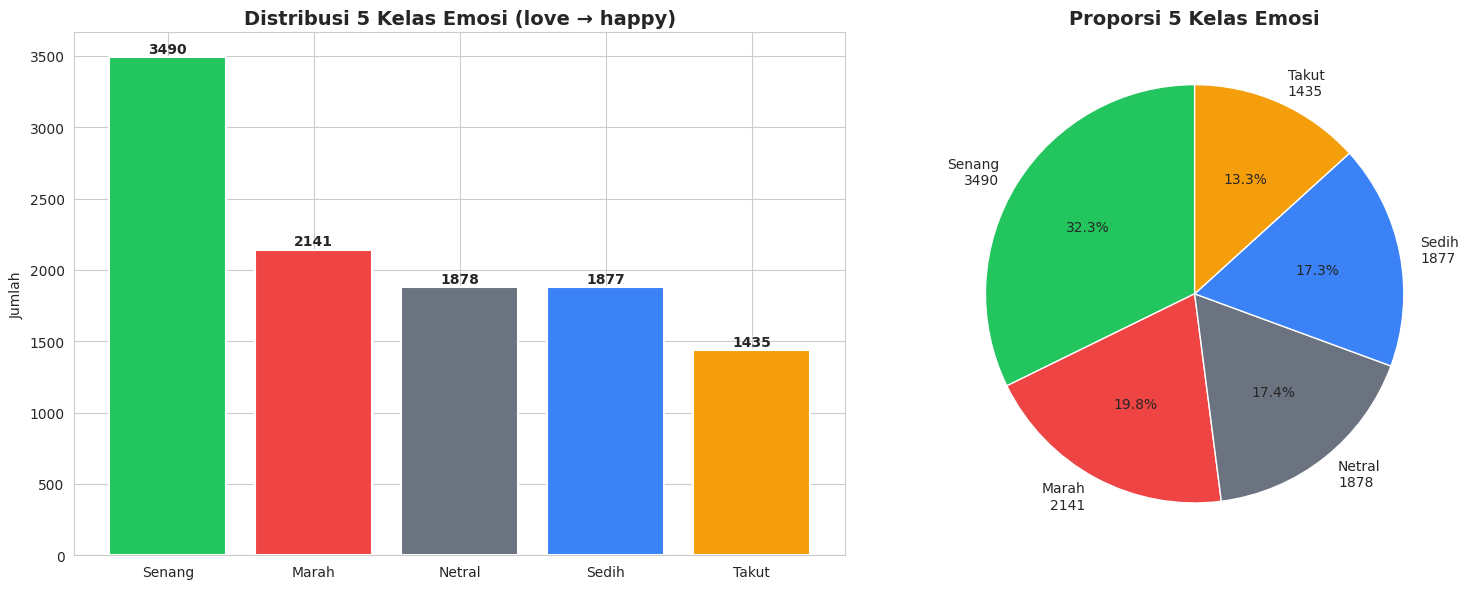

In [12]:
# Visualisasi distribusi 5 kelas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

counts = df['label_id'].value_counts()
colors = [COLOR_MAP[l] for l in counts.index]

bars = axes[0].bar(counts.index, counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Distribusi 5 Kelas Emosi (love → happy)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah')
for bar, val in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 str(val), ha='center', fontweight='bold')

axes[1].pie(counts.values, labels=[f'{l}\n{v}' for l, v in zip(counts.index, counts.values)],
            colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proporsi 5 Kelas Emosi', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('distribusi_5kelas.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 📖 Section 4 — Load Kamus Singkatan

In [13]:
def load_kamus(filepath):
    kamus = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if ';' in line:
                parts = line.split(';', 1)
                if len(parts) == 2:
                    kamus[parts[0].strip().lower()] = parts[1].strip().lower()
    return kamus

kamus_singkatan = load_kamus('kamus_singkatan.csv')
print(f'✅ Kamus singkatan: {len(kamus_singkatan)} entri')

✅ Kamus singkatan: 1243 entri


---
## 🔧 Section 5 — Preprocessing (Improved)

Pipeline 5 tahap dengan perbaikan:
- ✅ Kata negasi **dipertahankan** (tidak, bukan, jangan, belum)
- ✅ Normalisasi repetisi huruf ("senaangggg" → "senang")
- ✅ Dua versi: DENGAN dan TANPA stemming (dibandingkan)

In [14]:
# Stemmer
print('⏳ Menginisialisasi Sastrawi Stemmer...')
factory = StemmerFactory()
stemmer = factory.create_stemmer()
print('✅ Stemmer siap!')

# Stopwords — TANPA kata negasi
stop_words = set(stopwords.words('indonesian'))
negation_words = {'tidak', 'bukan', 'jangan', 'belum', 'tanpa', 'tak', 'tiada', 'kurang'}
stop_words -= negation_words

extra_sw = {
    'yg', 'nya', 'dg', 'aja', 'aj', 'nih', 'sih',
    'dong', 'deh', 'loh', 'kan', 'tuh', 'kalo', 'kl',
    'sm', 'jg', 'juga', 'itu', 'ini', 'ya', 'yaa',
    'wkwk', 'wkwkwk', 'wkwkwkwk', 'haha', 'hehe', 'hihi',
    'lol', 'username', 'url', 'rt', 'amp'
}
stop_words.update(extra_sw)
print(f'✅ Stopwords: {len(stop_words)} kata (negasi DIPERTAHANKAN)')

⏳ Menginisialisasi Sastrawi Stemmer...
✅ Stemmer siap!
✅ Stopwords: 777 kata (negasi DIPERTAHANKAN)


In [15]:
def normalisasi_singkatan(text):
    words = text.split()
    return ' '.join(kamus_singkatan.get(w.lower(), w) for w in words)

def case_folding(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # repetisi huruf
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenizing(text):
    return text.split()

def stopword_removal(tokens):
    return [t for t in tokens if t not in stop_words and len(t) > 1]

def stemming_sastrawi(tokens):
    return [stemmer.stem(t) for t in tokens]

def preprocess_with_stemming(text):
    text = normalisasi_singkatan(text)
    text = case_folding(text)
    tokens = tokenizing(text)
    tokens = stopword_removal(tokens)
    tokens = stemming_sastrawi(tokens)
    return ' '.join(tokens)

def preprocess_without_stemming(text):
    text = normalisasi_singkatan(text)
    text = case_folding(text)
    tokens = tokenizing(text)
    tokens = stopword_removal(tokens)
    return ' '.join(tokens)

# Demo
demo = 'gue gak seneng bgt sm dia, bikin kesel doang!! sayang padahal'
print(f'Original         : "{demo}"')
print(f'TANPA stemming   : "{preprocess_without_stemming(demo)}"')
print(f'DENGAN stemming  : "{preprocess_with_stemming(demo)}"')

Original         : "gue gak seneng bgt sm dia, bikin kesel doang!! sayang padahal"
TANPA stemming   : "tidak senang bikin kesal doang sayang"
DENGAN stemming  : "tidak senang bikin kesal doang sayang"


In [16]:
%%time
# Preprocessing TANPA stemming (~1 menit)
print(f'⏳ Preprocessing TANPA stemming ({len(df)} teks)...')
results = []
for i, text in enumerate(df['text']):
    results.append(preprocess_without_stemming(text))
    if (i + 1) % 2000 == 0:
        print(f'   ✔ {i+1}/{len(df)}')
df['text_no_stem'] = results
print(f'✅ Selesai!')

⏳ Preprocessing TANPA stemming (10821 teks)...
   ✔ 2000/10821
   ✔ 4000/10821
   ✔ 6000/10821
   ✔ 8000/10821
   ✔ 10000/10821
✅ Selesai!
CPU times: user 394 ms, sys: 196 µs, total: 394 ms
Wall time: 395 ms


In [17]:
%%time
# Preprocessing DENGAN stemming (~15-20 menit)
print(f'⏳ Preprocessing DENGAN stemming ({len(df)} teks)...')
print('   Estimasi 15-20 menit...')
results = []
for i, text in enumerate(df['text']):
    results.append(preprocess_with_stemming(text))
    if (i + 1) % 1000 == 0:
        print(f'   ✔ {i+1}/{len(df)}')
df['text_with_stem'] = results
print(f'✅ Selesai!')

⏳ Preprocessing DENGAN stemming (10821 teks)...
   Estimasi 15-20 menit...
   ✔ 1000/10821
   ✔ 2000/10821
   ✔ 3000/10821
   ✔ 4000/10821
   ✔ 5000/10821
   ✔ 6000/10821
   ✔ 7000/10821
   ✔ 8000/10821
   ✔ 9000/10821
   ✔ 10000/10821
✅ Selesai!
CPU times: user 40min 30s, sys: 1.76 s, total: 40min 32s
Wall time: 40min 58s


In [18]:
# Hapus baris kosong
before = len(df)
df = df[
    (df['text_no_stem'].str.strip().str.len() > 0) &
    (df['text_with_stem'].str.strip().str.len() > 0)
].reset_index(drop=True)
print(f'✅ Data bersih: {len(df)} teks ({before - len(df)} dihapus)')

✅ Data bersih: 10819 teks (2 dihapus)


In [20]:
# Label encoding
le = LabelEncoder()
y = le.fit_transform(df['label'])

print(f'✅ Label Encoding (5 kelas):')
for i, cls in enumerate(le.classes_):
    emoji = EMOJI_MAP[LABEL_MAP[cls]]
    count = (df['label'] == cls).sum()
    print(f'   {i} = {emoji} {LABEL_MAP[cls]:8s} ({count} data)')

# Split data (sama untuk semua eksperimen)
idx_train, idx_test = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=42, stratify=y
)
y_train = y[idx_train]
y_test = y[idx_test]

print(f'\n📊 Split: {len(idx_train)} training, {len(idx_test)} testing')

✅ Label Encoding (5 kelas):
   0 = 😡 Marah    (2141 data)
   1 = 😨 Takut    (1435 data)
   2 = 😊 Senang   (3490 data)
   3 = 😐 Netral   (1876 data)
   4 = 😢 Sedih    (1877 data)

📊 Split: 8655 training, 2164 testing


In [21]:
# Jalankan 8 eksperimen
experiments = [
    {'name': '1. NoStem + Unigram + MNB',   'col': 'text_no_stem',   'ngram': (1,1), 'model': 'mnb'},
    {'name': '2. NoStem + Bigram + MNB',    'col': 'text_no_stem',   'ngram': (1,2), 'model': 'mnb'},
    {'name': '3. NoStem + Trigram + MNB',   'col': 'text_no_stem',   'ngram': (1,3), 'model': 'mnb'},
    {'name': '4. Stem + Unigram + MNB',     'col': 'text_with_stem', 'ngram': (1,1), 'model': 'mnb'},
    {'name': '5. Stem + Bigram + MNB',      'col': 'text_with_stem', 'ngram': (1,2), 'model': 'mnb'},
    {'name': '6. Stem + Trigram + MNB',     'col': 'text_with_stem', 'ngram': (1,3), 'model': 'mnb'},
    {'name': '7. NoStem + Bigram + CNB',    'col': 'text_no_stem',   'ngram': (1,2), 'model': 'cnb'},
    {'name': '8. Stem + Bigram + CNB',      'col': 'text_with_stem', 'ngram': (1,2), 'model': 'cnb'},
]

results = []
print(f'{"Konfigurasi":38s} | {"Accuracy":10s} | {"F1-Score":10s}')
print('-' * 65)

for exp in experiments:
    tfidf = TfidfVectorizer(
        max_features=15000,
        ngram_range=exp['ngram'],
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )

    X_tr = tfidf.fit_transform(df[exp['col']].iloc[idx_train])
    X_te = tfidf.transform(df[exp['col']].iloc[idx_test])

    model = MultinomialNB(alpha=0.5) if exp['model'] == 'mnb' else ComplementNB(alpha=0.5)
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'name': exp['name'], 'accuracy': acc, 'f1_score': f1,
        'model_obj': model, 'tfidf_obj': tfidf, 'col': exp['col']
    })

    mark = ' 🏆' if acc == max(r['accuracy'] for r in results) else ''
    print(f'{exp["name"]:38s} | {acc*100:6.2f}%    | {f1:.4f}{mark}')

best = max(results, key=lambda x: x['accuracy'])
print(f'\n🏆 TERBAIK: {best["name"]} — Akurasi {best["accuracy"]*100:.2f}%')

Konfigurasi                            | Accuracy   | F1-Score  
-----------------------------------------------------------------
1. NoStem + Unigram + MNB              |  58.55%    | 0.5530 🏆
2. NoStem + Bigram + MNB               |  58.41%    | 0.5494
3. NoStem + Trigram + MNB              |  58.46%    | 0.5503
4. Stem + Unigram + MNB                |  57.76%    | 0.5465
5. Stem + Bigram + MNB                 |  58.41%    | 0.5499
6. Stem + Trigram + MNB                |  57.90%    | 0.5439
7. NoStem + Bigram + CNB               |  61.41%    | 0.5998 🏆
8. Stem + Bigram + CNB                 |  61.83%    | 0.6031 🏆

🏆 TERBAIK: 8. Stem + Bigram + CNB — Akurasi 61.83%


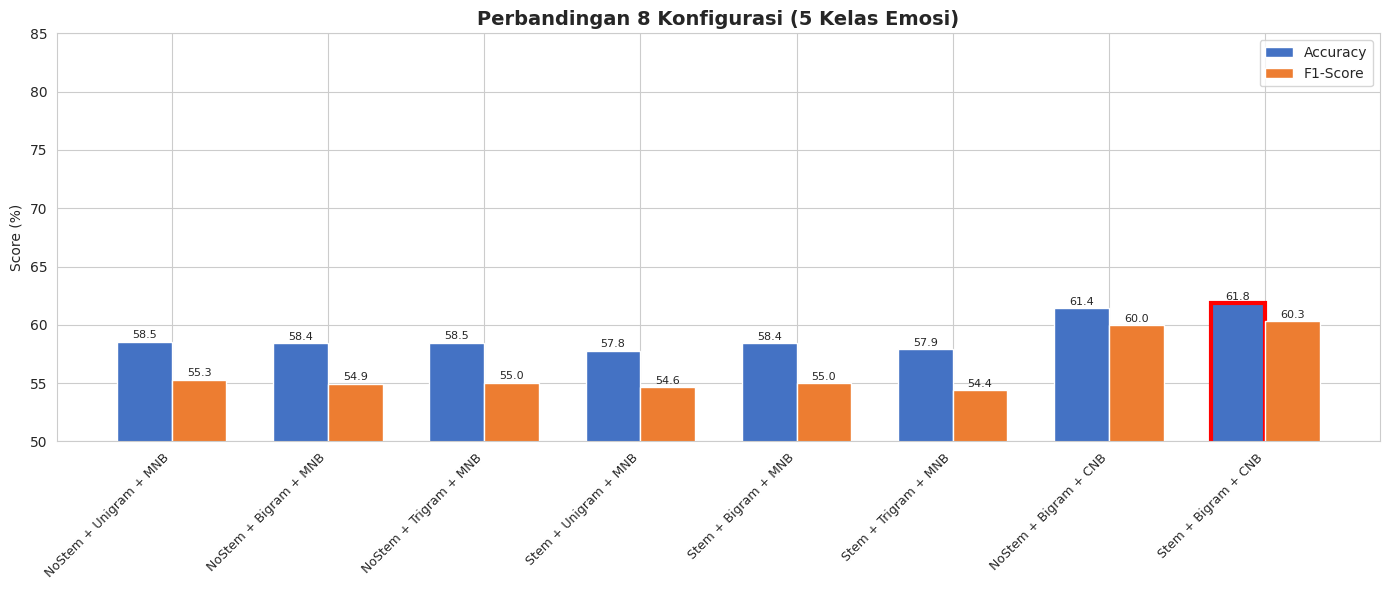

In [22]:
# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(14, 6))

names = [r['name'].split('. ')[1] for r in results]
accs = [r['accuracy'] * 100 for r in results]
f1s = [r['f1_score'] * 100 for r in results]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='#4472C4')
bars2 = ax.bar(x + width/2, f1s, width, label='F1-Score', color='#ED7D31')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Score (%)')
ax.set_title('Perbandingan 8 Konfigurasi (5 Kelas Emosi)', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim(50, 85)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}', ha='center', fontsize=8)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}', ha='center', fontsize=8)

best_idx = accs.index(max(accs))
bars1[best_idx].set_edgecolor('red')
bars1[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig('perbandingan_model_5kelas.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
print(f'🏆 Menggunakan: {best["name"]}\n')

best_model = best['model_obj']
best_tfidf = best['tfidf_obj']
best_col = best['col']

X_test_best = best_tfidf.transform(df[best_col].iloc[idx_test])
y_pred_best = best_model.predict(X_test_best)

acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, average='weighted')
rec = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

print(f'╔{"═"*42}╗')
print(f'║  HASIL MODEL TERBAIK (5 KELAS)          ║')
print(f'╠{"═"*42}╣')
print(f'║  Accuracy  : {acc:.4f} ({acc*100:.2f}%)            ║')
print(f'║  Precision : {prec:.4f}                      ║')
print(f'║  Recall    : {rec:.4f}                      ║')
print(f'║  F1-Score  : {f1:.4f}                      ║')
print(f'╚{"═"*42}╝')

print(f'\n📋 Classification Report:\n')
target_names = [f'{EMOJI_MAP[LABEL_MAP[c]]} {LABEL_MAP[c]}' for c in le.classes_]
print(classification_report(y_test, y_pred_best, target_names=target_names))

🏆 Menggunakan: 8. Stem + Bigram + CNB

╔══════════════════════════════════════════╗
║  HASIL MODEL TERBAIK (5 KELAS)          ║
╠══════════════════════════════════════════╣
║  Accuracy  : 0.6183 (61.83%)            ║
║  Precision : 0.6045                      ║
║  Recall    : 0.6183                      ║
║  F1-Score  : 0.6031                      ║
╚══════════════════════════════════════════╝

📋 Classification Report:

              precision    recall  f1-score   support

     😡 Marah       0.60      0.74      0.66       428
     😨 Takut       0.59      0.69      0.64       287
    😊 Senang       0.70      0.79      0.74       698
    😐 Netral       0.47      0.28      0.35       375
     😢 Sedih       0.57      0.45      0.50       376

    accuracy                           0.62      2164
   macro avg       0.59      0.59      0.58      2164
weighted avg       0.60      0.62      0.60      2164



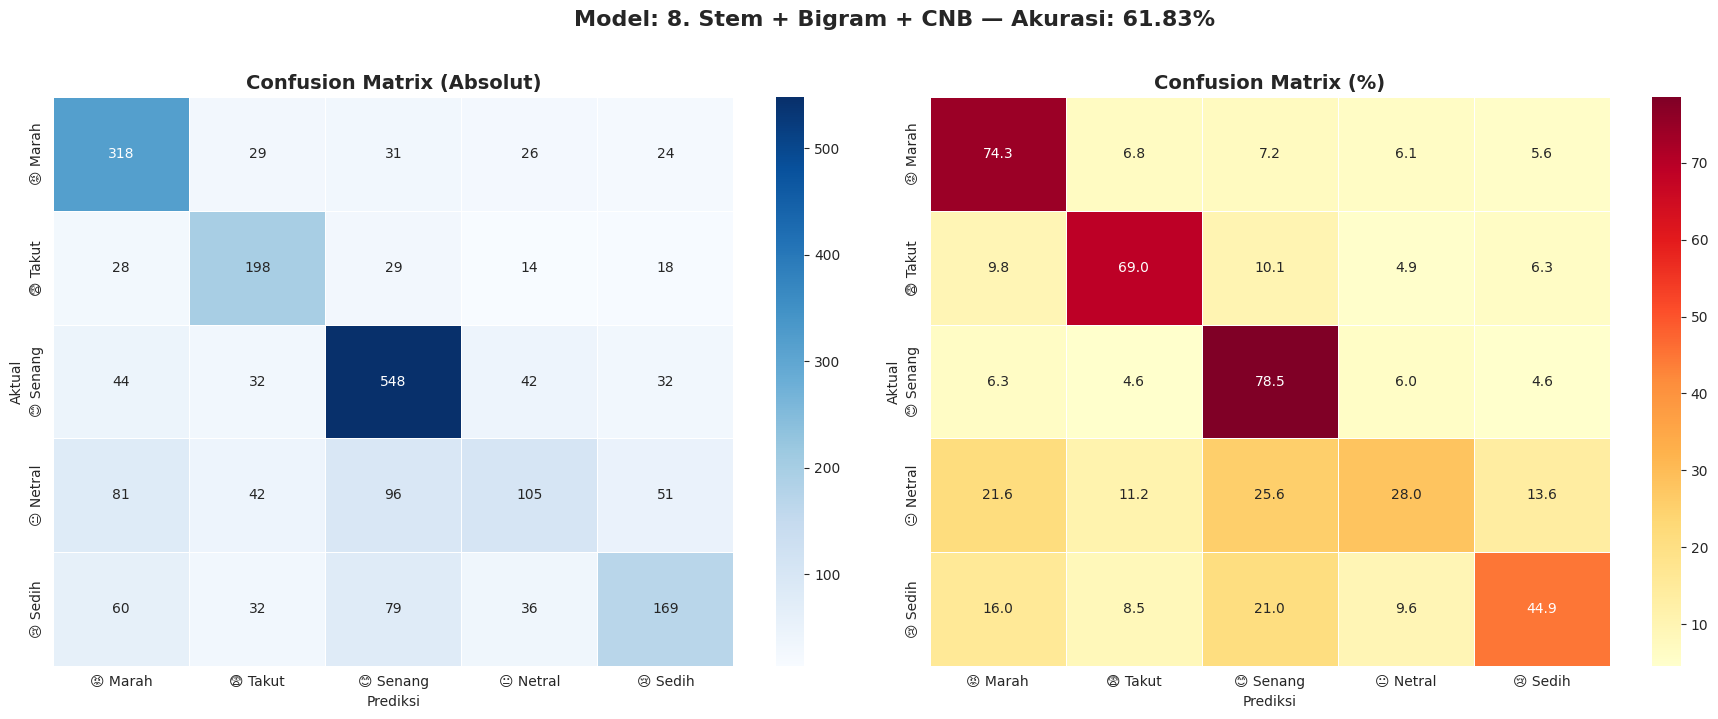

In [24]:
cm = confusion_matrix(y_test, y_pred_best)
cm_labels = [f'{EMOJI_MAP[LABEL_MAP[c]]} {LABEL_MAP[c]}' for c in le.classes_]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Absolut
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=cm_labels,
            linewidths=0.5, ax=axes[0])
axes[0].set_title('Confusion Matrix (Absolut)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

# Persentase
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='YlOrRd',
            xticklabels=cm_labels, yticklabels=cm_labels,
            linewidths=0.5, ax=axes[1])
axes[1].set_title('Confusion Matrix (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.suptitle(f'Model: {best["name"]} — Akurasi: {acc*100:.2f}%', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrix_5kelas.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Analisis per kelas
print('📊 Analisis Per Kelas Emosi:\n')
for i, cls in enumerate(le.classes_):
    cls_mask = y_test == i
    cls_acc = accuracy_score(y_test[cls_mask], y_pred_best[cls_mask])
    total = cls_mask.sum()
    correct = (y_pred_best[cls_mask] == i).sum()
    emoji = EMOJI_MAP[LABEL_MAP[cls]]
    bar = '█' * int(cls_acc * 30)
    print(f'   {emoji} {LABEL_MAP[cls]:7s}: {cls_acc*100:5.1f}% ({correct}/{total}) {bar}')

📊 Analisis Per Kelas Emosi:

   😡 Marah  :  74.3% (318/428) ██████████████████████
   😨 Takut  :  69.0% (198/287) ████████████████████
   😊 Senang :  78.5% (548/698) ███████████████████████
   😐 Netral :  28.0% (105/375) ████████
   😢 Sedih  :  44.9% (169/376) █████████████


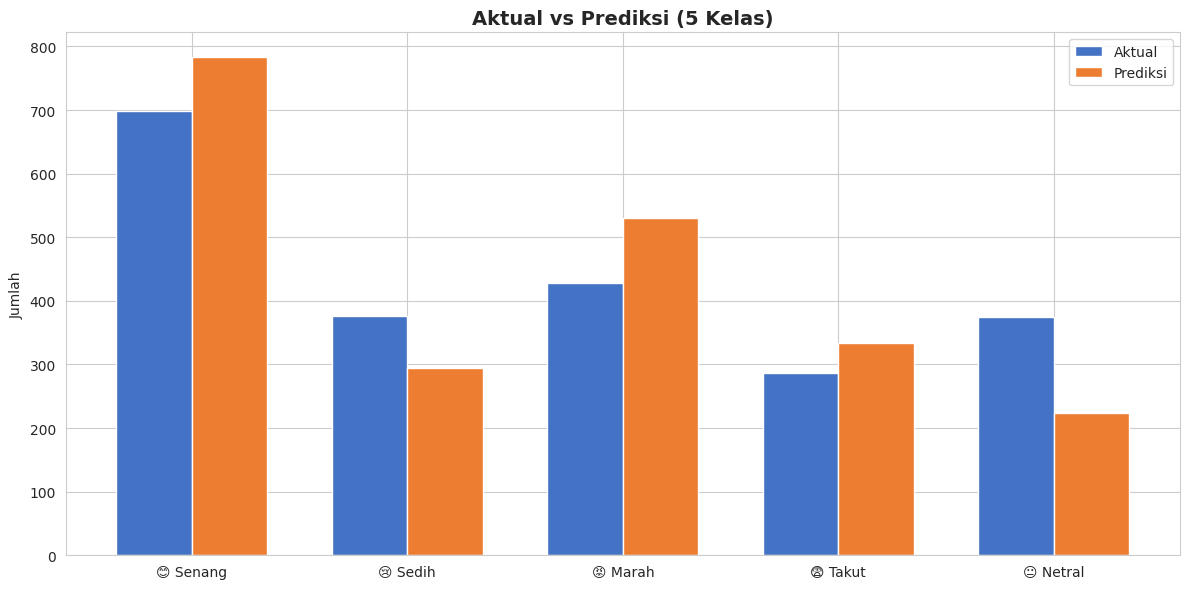

In [27]:
# Perbandingan Aktual vs Prediksi
fig, ax = plt.subplots(figsize=(12, 6))

decoded_test = [LABEL_MAP[l] for l in le.inverse_transform(y_test)]
decoded_pred = [LABEL_MAP[l] for l in le.inverse_transform(y_pred_best)]
all_labels = list(LABEL_MAP.values())

x_pos = np.arange(len(all_labels))
test_counts = [decoded_test.count(n) for n in all_labels]
pred_counts = [decoded_pred.count(n) for n in all_labels]
width = 0.35

ax.bar(x_pos - width/2, test_counts, width, label='Aktual', color='#4472C4')
ax.bar(x_pos + width/2, pred_counts, width, label='Prediksi', color='#ED7D31')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{EMOJI_MAP[l]} {l}' for l in all_labels])
ax.set_title('Aktual vs Prediksi (5 Kelas)', fontsize=14, fontweight='bold')
ax.set_ylabel('Jumlah')
ax.legend()
plt.tight_layout()
plt.savefig('aktual_vs_prediksi_5kelas.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
os.makedirs('model', exist_ok=True)

uses_stemming = 'stem' in best_col.lower()

with open('model/model_nb.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print('✅ model/model_nb.pkl')

with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(best_tfidf, f)
print('✅ model/tfidf_vectorizer.pkl')

with open('model/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print('✅ model/label_encoder.pkl')

with open('model/kamus_singkatan.pkl', 'wb') as f:
    pickle.dump(kamus_singkatan, f)
print('✅ model/kamus_singkatan.pkl')

config = {
    'version': 'v3',
    'num_classes': 5,
    'classes': list(le.classes_),
    'best_experiment': best['name'],
    'accuracy': float(acc),
    'f1_score': float(f1),
    'uses_stemming': uses_stemming,
    'negation_preserved': True,
    'love_merged_to_happy': True,
    'min_text_length': 20,
}
with open('model/config.pkl', 'wb') as f:
    pickle.dump(config, f)
print('✅ model/config.pkl')

print(f'\n📌 Konfigurasi model:')
for k, v in config.items():
    print(f'   {k}: {v}')

print(f'\n📦 Ukuran file:')
for fname in sorted(os.listdir('model')):
    size = os.path.getsize(f'model/{fname}')
    unit = 'MB' if size > 1024*1024 else 'KB'
    val = size/1024/1024 if size > 1024*1024 else size/1024
    print(f'   {fname:30s} {val:.1f} {unit}')

✅ model/model_nb.pkl
✅ model/tfidf_vectorizer.pkl
✅ model/label_encoder.pkl
✅ model/kamus_singkatan.pkl
✅ model/config.pkl

📌 Konfigurasi model:
   version: v3
   num_classes: 5
   classes: ['anger', 'fear', 'happy', 'neutral', 'sadness']
   best_experiment: 8. Stem + Bigram + CNB
   accuracy: 0.6182994454713494
   f1_score: 0.6030851078953885
   uses_stemming: True
   negation_preserved: True
   love_merged_to_happy: True
   min_text_length: 20

📦 Ukuran file:
   config.pkl                     0.3 KB
   kamus_singkatan.pkl            20.4 KB
   label_encoder.pkl              0.3 KB
   model_nb.pkl                   1.2 MB
   tfidf_vectorizer.pkl           526.6 KB


In [29]:
preprocess_fn = preprocess_with_stemming if uses_stemming else preprocess_without_stemming

def predict_emosi(text):
    clean = preprocess_fn(text)
    vec = best_tfidf.transform([clean])
    pred = best_model.predict(vec)[0]
    proba = best_model.predict_proba(vec)[0]
    label_en = le.inverse_transform([pred])[0]
    label_id = LABEL_MAP[label_en]
    return {
        'text': text,
        'clean': clean,
        'emosi': f'{EMOJI_MAP[label_id]} {label_id}',
        'label_en': label_en,
        'confidence': float(max(proba)),
        'probabilitas': {LABEL_MAP[c]: round(float(p), 4)
                         for c, p in zip(le.classes_, proba)}
    }


contoh_teks = [
    'aku senang banget hari ini dapat nilai bagus',
    'sayang kamu lebih dari apapun di dunia ini',
    'sedih rasanya ditinggal pergi sama orang yang disayang',
    'gue bener bener kesel sama orang itu dasar goblok',
    'takut banget mau ujian besok belum belajar sama sekali',
    'hari ini biasa aja sih ga ada yang spesial',
    'alhamdulillah akhirnya lulus sidang semoga berkah',
    'tidak senang sama sekali dengan keputusan ini',
    'jangan takut gagal yang penting sudah berusaha',
    'kenapa ya orang suka banget nyinyir di medsos',
]

print(f'🎮 DEMO PREDIKSI — 5 Kelas (model: {best["name"]})\n')
print('=' * 70)
for teks in contoh_teks:
    r = predict_emosi(teks)
    print(f'\n📝 "{teks}"')
    print(f'🎯 {r["emosi"]} ({r["confidence"]*100:.1f}%)')
    for emo, prob in sorted(r['probabilitas'].items(), key=lambda x: -x[1]):
        bar = '█' * int(prob * 40)
        print(f'   {EMOJI_MAP[emo]} {emo:7s}: {prob:.4f} {bar}')
    print('-' * 70)

🎮 DEMO PREDIKSI — 5 Kelas (model: 8. Stem + Bigram + CNB)


📝 "aku senang banget hari ini dapat nilai bagus"
🎯 😐 Netral (24.0%)
   😐 Netral : 0.2400 █████████
   😊 Senang : 0.2218 ████████
   😢 Sedih  : 0.1928 ███████
   😡 Marah  : 0.1731 ██████
   😨 Takut  : 0.1723 ██████
----------------------------------------------------------------------

📝 "sayang kamu lebih dari apapun di dunia ini"
🎯 😊 Senang (31.8%)
   😊 Senang : 0.3177 ████████████
   😢 Sedih  : 0.1867 ███████
   😐 Netral : 0.1795 ███████
   😨 Takut  : 0.1608 ██████
   😡 Marah  : 0.1553 ██████
----------------------------------------------------------------------

📝 "sedih rasanya ditinggal pergi sama orang yang disayang"
🎯 😢 Sedih (38.7%)
   😢 Sedih  : 0.3874 ███████████████
   😊 Senang : 0.2152 ████████
   😐 Netral : 0.1448 █████
   😨 Takut  : 0.1363 █████
   😡 Marah  : 0.1163 ████
----------------------------------------------------------------------

📝 "gue bener bener kesel sama orang itu dasar goblok"
🎯 😡 Marah (66.5%)


In [31]:
# 🎯 Coba sendiri!
teks_kamu = 'malas'

r = predict_emosi(teks_kamu)
print(f'📝 "{r["text"]}"')
print(f'🎯 {r["emosi"]} ({r["confidence"]*100:.1f}%)')
for emo, prob in sorted(r['probabilitas'].items(), key=lambda x: -x[1]):
    print(f'   {EMOJI_MAP[emo]} {emo:7s}: {prob:.4f}')

📝 "malas"
🎯 😐 Netral (20.7%)
   😐 Netral : 0.2073
   😡 Marah  : 0.2046
   😢 Sedih  : 0.1986
   😨 Takut  : 0.1984
   😊 Senang : 0.1910
